# kuzushiji-MNIST with SciKit-Learn and skorch

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [ ]:
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz
!wget http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz

--2024-07-28 22:08:55--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18384171 (18M)
Saving to: ‘kmnist-train-imgs.npz’

kmnist-train-imgs.n 100%[===================>]  17.53M  1.32MB/s    in 15s     

2024-07-28 22:09:10 (1.20 MB/s) - ‘kmnist-train-imgs.npz’ saved [18384171/18384171]

--2024-07-28 22:09:10--  http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29700 (29K)
Saving to: ‘kmnist-train-labels.npz’

kmnist-train-labels 100%[===================>]  29.00K  --.-KB/s    in 0.1s    

2024-07-28 22:09:10 (264 KB/s) - ‘kmnist-train-labels.npz’ saved [29700/29

In [ ]:
def load(f):
    return np.load(f)['arr_0']

# Load the data
X_train = load('kmnist-train-imgs.npz')
X_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
X_train[0].shape, X_test[0].shape

((28, 28), (28, 28))

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 28*28))
X_test = X_test.reshape((X_test.shape[0], 28*28))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y, n=5):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:n].reshape(n, 28, 28), y[:n])):
        plt.figure(figsize=(1.5 * n, 1.5 * n))
        plt.subplot(1, n, 1 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

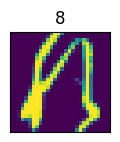

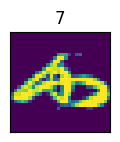

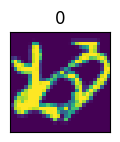

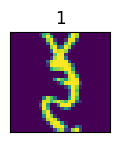

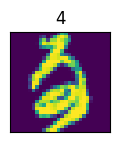

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:

torch.manual_seed(0)

module = Cnn()
cnn = NeuralNetClassifier(
    module,
    max_epochs=3,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
adversaries_x = torch.tensor(X_test).to(device)
adversaries_y = torch.tensor(y_test).to(device)
epsilon = 10 / 255

In [ ]:
step = 500
for i in range(10):
  adversaries_x = adversaries_x.to(device)
  cnn.fit(adversaries_x, adversaries_y)
  loss = nn.CrossEntropyLoss()
  inp = adversaries_x
  inp.requires_grad = True
  for j in range(0, inp.shape[0], step):
    module.eval()
    out = cnn.module(inp[j:j + step])
    loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))
    loss_val.backward()
    delta = epsilon * torch.sign(inp.grad.detach()[j:j + step])
    if j == 0:
      adversaries_x = torch.clamp(inp.detach()[j:j + step] + delta, 0.0, 1)
    else:
      adversaries_x = torch.cat((adversaries_x.detach(), torch.clamp(inp.detach()[j:j + step] + delta, 0.0, 1)), 0)
attacked = adversaries_x.cpu().detach().numpy()

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6888       0.6985        0.9877  1.1511
      2        1.0410       0.8160        0.6146  0.3198
      3        0.8216       0.8570        0.4873  0.3133
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-14-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9364       0.8235        0.6120  0.3199
      2        0.7735       0.8595        0.4924  0.3043
      3        0.6971       0.8760        0.4349  0.3144
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-14-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8711       0.8205        0.5947  0.3240
      2        0.7808       0.8445        0.5328  0.3034
      3        0.7138       0.8530        0.4844  0.3045
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-14-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9041       0.8065        0.6428  0.3113
      2        0.8203       0.8325        0.5770  0.3020
      3        0.7686       0.8395        0.5418  0.3141
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-14-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9673       0.7755        0.7403  0.3047
      2        0.8799       0.7965        0.6592  0.3728
      3        0.8252       0.8110        0.6220  0.3886
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-14-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0486       0.7470        0.8128  0.4044
      2        0.9677       0.7655        0.7620  0.4116
      3        0.9004       0.7885        0.6818  0.3891
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-14-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1546       0.7050        0.9254  0.3648
      2        1.0378       0.7295        0.8464  0.2970
      3        0.9841       0.7425        0.7823  0.2988
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-14-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2168       0.6590        1.0277  0.3240
      2        1.1370       0.6990        0.9503  0.2972
      3        1.0696       0.7255        0.8549  0.3006
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-14-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3022       0.6320        1.1178  0.3097
      2        1.1847       0.6755        1.0028  0.2978
      3        1.1073       0.7230        0.8910  0.3046
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-14-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3706       0.6275        1.1448  0.3060
      2        1.2267       0.6770        1.0111  0.2987
      3        1.1405       0.7105        0.9256  0.3257


<ipython-input-14-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


In [ ]:
mnist_dim = 28 * 28
hidden_dims = [int(mnist_dim/8)]
output_dim = 10

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [ ]:
from skorch import NeuralNetClassifier
nets = []

In [ ]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
X_train.shape, y_train.shape, 3584*28, 2352*100, 28*28*3

((60000, 784), (60000,), 100352, 235200, 2352)

In [ ]:
net1.fit(X_train, y_train)
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0346       0.8288        0.5873  1.1012
      2        0.6281       0.8632        0.4563  1.0681
      3        0.5362       0.8812        0.3989  1.0574
      4        0.4877       0.8908        0.3614  1.0462
      5        0.4532       0.8976        0.3380  1.0936
      6        0.4285       0.9041        0.3189  1.3521
      7        0.4121       0.9070        0.3084  1.4659
      8        0.3891       0.9122        0.2945  1.0749
      9        0.3816       0.9137        0.2890  1.0483
     10        0.3709       0.9176        0.2768  1.0852
     11        0.3621       0.9197        0.2743  1.0356
     12        0.3529       0.9203        0.2685  1.0813
     13        0.3476       0.9228        0.2620  1.0386
     14        0.3374       0.9226        0.2593  1.0639
     15        0.3345       0.9239        0.2552  1.0700
     16        0.3226       0.9

In [ ]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

0.8435

In [ ]:
y_pred = net1.predict(attacked)
accuracy_score(y_test, y_pred)

0.5043

In [ ]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3532       0.7967        0.6833  1.1596
      2        0.7749       0.8468        0.5046  1.1264
      3        0.6310       0.8722        0.4235  1.1111
      4        0.5383       0.8813        0.3838  1.1256
      5        0.4815       0.8923        0.3527  1.1072
      6        0.4338       0.9034        0.3183  1.1357
      7        0.4025       0.9067        0.3044  1.3466
      8        0.3688       0.9068        0.3009  1.5554
      9        0.3485       0.9146        0.2788  1.1666
     10        0.3246       0.9170        0.2742  1.1021
     11        0.3073       0.9217        0.2641  1.1120
     12        0.2909       0.9227        0.2595  1.1090
     13        0.2778       0.9229        0.2595  1.1101
     14        0.2603       0.9261        0.2561  1.1165
     15        0.2541       0.9265        0.2512  1.1043
     16        0.2403       0.9

In [ ]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

0.8437

In [ ]:
y_pred = net2.predict(attacked)
accuracy_score(y_test, y_pred)

0.4744

In [ ]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2488       0.8082        0.6553  1.1514
      2        0.7192       0.8512        0.4977  1.1247
      3        0.5882       0.8752        0.4148  1.1534
      4        0.5125       0.8866        0.3787  1.1394
      5        0.4588       0.8947        0.3489  1.1212
      6        0.4148       0.9025        0.3296  1.1165
      7        0.3867       0.9057        0.3129  1.1225
      8        0.3628       0.9114        0.2963  1.5592
      9        0.3421       0.9121        0.2938  1.3573
     10        0.3289       0.9127        0.2910  1.1336
     11        0.3099       0.9130        0.2937  1.1215
     12        0.2969       0.9193        0.2754  1.1264
     13        0.2870       0.9183        0.2744  1.1216
     14        0.2746       0.9220        0.2716  1.1197
     15        0.2641       0.9213        0.2706  1.1011
     16        0.2578       0.9

In [ ]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

0.8377

In [ ]:
y_pred = net3.predict(attacked)
accuracy_score(y_test, y_pred)

0.4818

In [ ]:
error_mask = y_pred != y_test

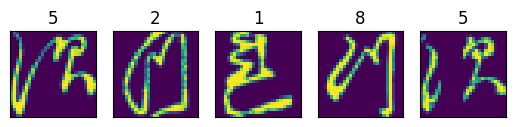

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [ ]:
[mnist_dim//4, mnist_dim//2]

[196, 392]

In [ ]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3308       0.8067        0.6607  1.1826
      2        0.7449       0.8502        0.4969  1.1180
      3        0.6108       0.8740        0.4186  1.1455
      4        0.5299       0.8861        0.3716  1.1111
      5        0.4709       0.8996        0.3342  1.4606
      6        0.4300       0.9039        0.3137  1.8679
      7        0.3890       0.9107        0.3002  1.5100
      8        0.3616       0.9136        0.2887  1.3773
      9        0.3421       0.9145        0.2878  1.1233
     10        0.3203       0.9199        0.2736  1.1276
     11        0.3038       0.9190        0.2696  1.1385
     12        0.2911       0.9203        0.2733  1.1290
     13        0.2760       0.9229        0.2628  1.1358
     14        0.2644       0.9247        0.2594  1.1163
     15        0.2572       0.9227        0.2665  1.1726
     16        0.2476       0.9

In [ ]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.8445

In [ ]:
y_pred = net4.predict(attacked)
accuracy_score(y_test, y_pred)

0.4721

In [ ]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3039       0.1185        2.3021  1.3355
      2        2.2993       0.1670        2.2794  1.3109
      3        2.0837       0.2172        1.8849  1.3150
      4        1.9153       0.2968        1.7357  1.2984
      5        1.6495       0.5647        1.2818  1.3233
      6        1.3545       0.6727        1.0506  1.5684
      7        1.1882       0.7339        0.8896  1.7257
      8        1.0765       0.7749        0.7971  1.2766
      9        0.9723       0.8135        0.6871  1.3125
     10        0.8881       0.8101        0.6761  1.2876
     11        0.8366       0.8323        0.6305  1.2785
     12        0.8116       0.8397        0.6100  1.2959
     13        0.7607       0.8482        0.5971  1.3368
     14        0.7294       0.8542        0.5684  1.2893
     15        0.7138       0.8540        0.5668  1.6299
     16        0.6960       0.8

In [ ]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.7429

In [ ]:
y_pred = net5.predict(attacked)
accuracy_score(y_test, y_pred)

0.3963

# Convolutional Network


In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8320       0.9183        0.2745  2.1193
      2        0.4532       0.9425        0.1956  1.8364
      3        0.3769       0.9517        0.1609  2.2384
      4        0.3438       0.9568        0.1454  1.7981
      5        0.3170       0.9590        0.1352  1.7932
      6        0.2950       0.9628        0.1224  1.8037
      7        0.2780       0.9649        0.1117  1.7879
      8        0.2630       0.9678        0.1098  1.8105
      9        0.2545       0.9681        0.1029  1.9882
     10        0.2429       0.9699        0.0989  2.0873


In [ ]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9174

In [ ]:
y_pred = cnn.predict(attacked)
accuracy_score(y_test, y_pred)

0.3386

In [ ]:
X_test.shape

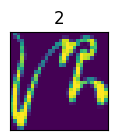

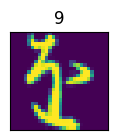

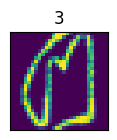

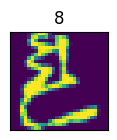

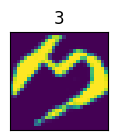

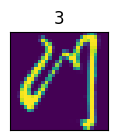

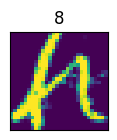

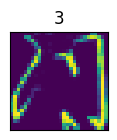

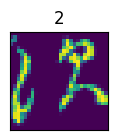

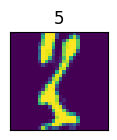

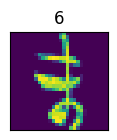

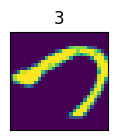

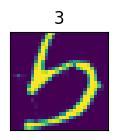

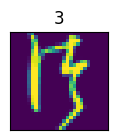

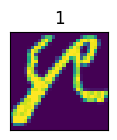

In [ ]:
plot_example(X_test, y_test, n=15)

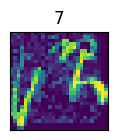

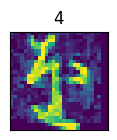

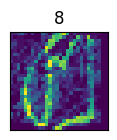

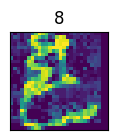

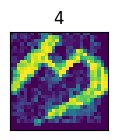

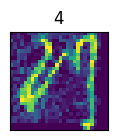

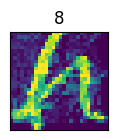

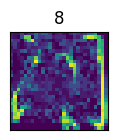

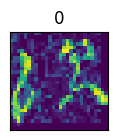

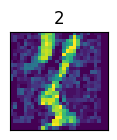

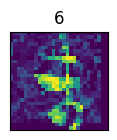

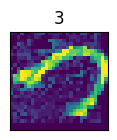

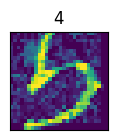

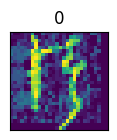

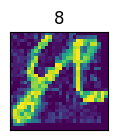

In [ ]:
plot_example(attacked, y_pred, n=15)